Import, load data

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from static_delay_interaction import DBN_static_delay as DBNstat
df = pd.read_csv('data/dataset_v2_1.csv')
data = np.loadtxt("data/buffer_block_zurich_chur_2019_v2.csv",dtype=str, delimiter=",")
nodes_data = np.loadtxt("data/szu_coordinates_nodes.csv", delimiter=",", skiprows=1)
edges_data = np.loadtxt("data/szu_coordinates_edges.csv", delimiter=",", skiprows=1)

In [18]:
nodes_ids = nodes_data[:, 0]
nodes_x = nodes_data[:, 1]
nodes_y = nodes_data[:, 2]

edges_source = edges_data[:, 0]
edges_target = edges_data[:, 1]
edges_resource = edges_data[:, 2] 

Gathering data from runs

In [19]:
spatial_series = np.load("simdata/primary_delays.npy", allow_pickle=True)
spatial_series_prim = np.load("simdata/secondary_delays.npy", allow_pickle=True)

In [20]:
mean_data= spatial_series[0,0,:,:]
mean_data_prim= spatial_series_prim[0,0,:,:]
mean_data_prim =  np.cumsum(mean_data_prim, axis=1)

firstthird = int(1.5*mean_data.shape[1]/40)
secondthids = int(6.5*mean_data.shape[1]/40)
lasteventthird = int(10.5*mean_data.shape[1]/40)
mean_data = np.cumsum(mean_data, axis=1)

mean_data_firstthird = np.mean(mean_data[:, :firstthird], axis=1)
mean_data_secondthird = np.mean(mean_data[:, firstthird:secondthids], axis=1)
mean_data_lastthird = np.mean(mean_data[:, secondthids:secondthids+1000], axis=1)

mean_data_firstthird_prim = np.mean(mean_data_prim[:, :firstthird], axis=1)
mean_data_secondthird_prim = np.mean(mean_data_prim[:, firstthird:secondthids], axis=1)
mean_data_lastthird_prim = np.mean(mean_data_prim[:, secondthids:secondthids+1000], axis=1)

In [21]:
print(mean_data_firstthird.mean())
print(mean_data_firstthird_prim.mean())

print(mean_data_firstthird.std())
print(mean_data_firstthird_prim.std())

print(mean_data_secondthird.mean())
print(mean_data_secondthird_prim.mean())

print(mean_data_secondthird.std())
print(mean_data_secondthird_prim.std())

print(mean_data_lastthird.mean())
print(mean_data_lastthird_prim.mean())

print(mean_data_lastthird.std())
print(mean_data_lastthird_prim.std())



9.685942109160635
-3.6620505754563357
9.70099641426627
26.50733053196301
52.405452592698026
-26.922266603740717
38.45404165254421
149.4503021139999
91.22583257098503
-46.77661005483415
64.15926801269211
269.1380287589943


Separating data in timeslices

In [22]:
lowerlim = 1000
upperlim = 1000

block_id_mean_V = {}
block_id_mean_V_data = {}
event_blocks = []

block_ids = np.load("data/block_ids.npy", allow_pickle=True)
blocks_in_data = np.load("data/blocks_in_data.npy", allow_pickle=True)
block_map = np.load("data/block_map.npy", allow_pickle=True).item()
block_map_reverse = {v: k for k, v in block_map.items()}

for unique_block in np.unique(block_ids):
    v_ids = np.where(event_blocks == unique_block)[0]
    firstevent, lastevent = lasteventthird-lowerlim, lasteventthird + upperlim
    v_ids = v_ids[(v_ids>firstevent) & (v_ids<lastevent)]
    v_values = mean_data[unique_block, v_ids]
    v_mean = np.mean(v_values)
    v_mean = mean_data[unique_block, lastevent]
    block_id_mean_V[unique_block] = (v_mean)
    block_id_mean_V_data[block_map_reverse[unique_block]] = (v_mean)

block_id_mean_V_firstthird = {}
block_id_mean_V_data_firstthird = {}
for unique_block in np.unique(block_ids):
    v_ids = np.where(event_blocks == unique_block)[0]
    firstevent, lastevent = firstthird-lowerlim, firstthird + upperlim
    v_ids = v_ids[(v_ids>firstevent) & (v_ids<lastevent)]
    v_values = mean_data[unique_block, v_ids]
    v_mean = np.mean(v_values)
    v_mean = mean_data[unique_block, firstthird]
    block_id_mean_V_firstthird[unique_block] = (v_mean)
    block_id_mean_V_data_firstthird[block_map_reverse[unique_block]] = (v_mean)

block_id_mean_V_secondthird = {}
block_id_mean_V_data_secondthird = {}
for unique_block in np.unique(block_ids):
    v_ids = np.where(event_blocks == unique_block)[0]
    v_ids = v_ids[(v_ids>secondthids-lowerlim) & (v_ids<secondthids+upperlim)]
    v_values = mean_data[unique_block, v_ids]
    v_mean = np.mean(v_values)
    v_mean = mean_data[unique_block, secondthids]
    block_id_mean_V_secondthird[unique_block] = (v_mean)
    block_id_mean_V_data_secondthird[block_map_reverse[unique_block]] = (v_mean)

Block data analysis

In [23]:
blocks_in_data = np.load("data/blocks_in_data.npy", allow_pickle=True)

unique_blocks = np.unique(blocks_in_data)
block_nodes = {bs: set() for bs in unique_blocks}

edgelist = []
edgelens = []

for block_id in unique_blocks:
    block_is_source = np.where(edges_source == block_id)
    block_is_target = np.where(edges_target == block_id)
    
    for idx, blockid in enumerate(block_is_source):
        source = block_id
        source_node_id = np.where(nodes_ids == source)[0][0]
        source_coord = nodes_x[source_node_id], nodes_y[source_node_id]
        target = edges_target[blockid[idx]]
        target_node_id = np.where(nodes_ids == target)[0][0]
        target_coord = nodes_x[target_node_id], nodes_y[target_node_id]
        edgelens.append([int(source), int(target), np.linalg.norm(np.array(source_coord) - np.array(target_coord))])
        # print(np.linalg.norm(np.array(source_coord) - np.array(target_coord)))
        edgelist.append((source, target))

    
    for idx, blockid in enumerate(block_is_target):
        source = edges_source[blockid[idx]]
        target = block_id
        edgelist.append((source, target))
        source_node_id = np.where(nodes_ids == source)[0][0]
        source_coord = nodes_x[source_node_id], nodes_y[source_node_id]
        target = edges_target[blockid[idx]]
        target_node_id = np.where(nodes_ids == target)[0][0]
        target_coord = nodes_x[target_node_id], nodes_y[target_node_id]
        edgelens.append([int(source), int(target), np.linalg.norm(np.array(source_coord) - np.array(target_coord))])


Create initial graph

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

unique_blocks = np.unique(block_ids)
block_map = np.load("data/block_map.npy", allow_pickle=True).item()
block_map_reverse = {v: k for k, v in block_map.items()}
G = nx.DiGraph()

for node_idx, node in enumerate(nodes_data[:,0]):
    x = nodes_x[node_idx]
    y = nodes_y[node_idx]
    G.add_node(int(node), pos=(x, y))

for source, target in edgelist:
    G.add_edge(int(source), int(target))

total_nodes = np.unique(np.concatenate((edges_source, edges_target)))
v_list_official = []
nodeidsdict = {}
for i, block in enumerate(total_nodes):
    try:
        mean_v = block_id_mean_V_data[block]
        v_list_official.append(mean_v)
        nodeidsdict[block] = i
    except KeyError:
        mean_v = -420
        v_list_official.append(mean_v)
        nodeidsdict[block] = i

v_list_official_firstthird = []
for i, block in enumerate(total_nodes):
    try:
        mean_v = block_id_mean_V_data_firstthird[block]
        v_list_official_firstthird.append(mean_v)
    except KeyError:
        mean_v = -420
        v_list_official_firstthird.append(mean_v)

v_list_official_secondthird = []
for i, block in enumerate(total_nodes):
    try:
        mean_v = block_id_mean_V_data_secondthird[block]
        v_list_official_secondthird.append(mean_v)
    except KeyError:
        mean_v = -420
        v_list_official_secondthird.append(mean_v)

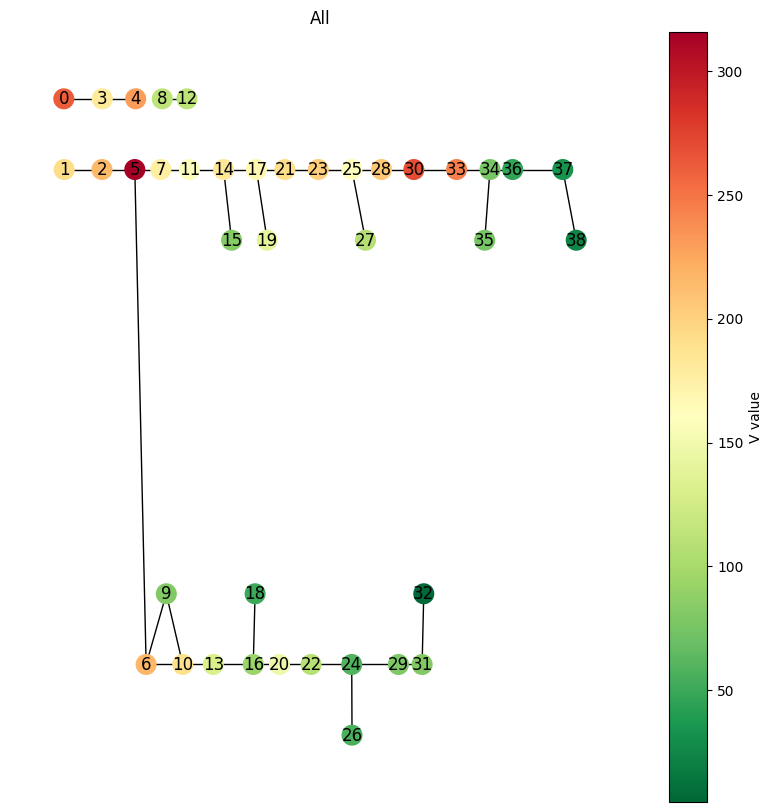

All - Mean V: 140.1263


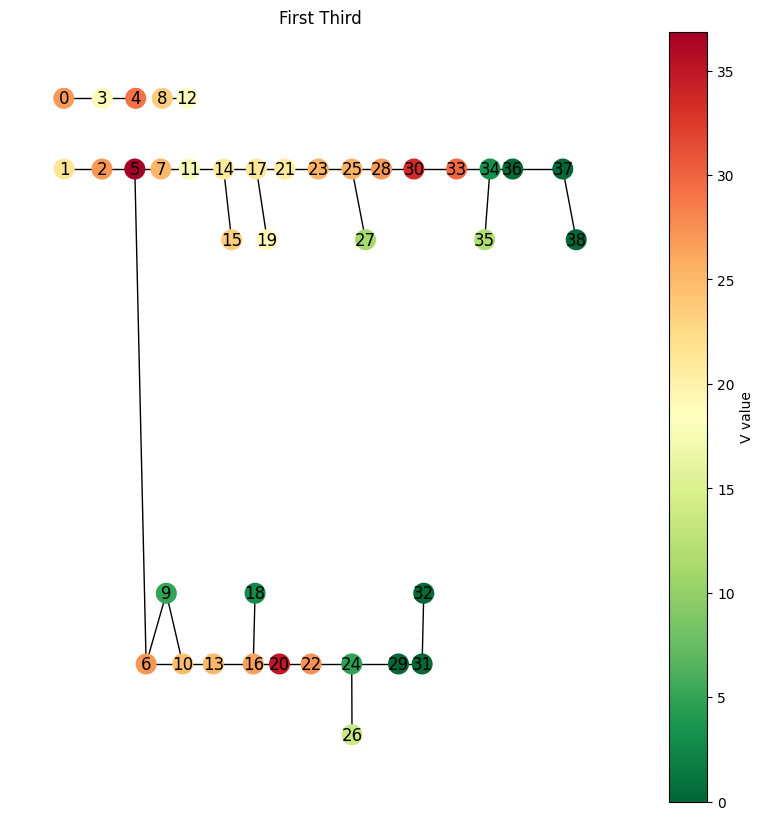

First Third - Mean V: 18.1686


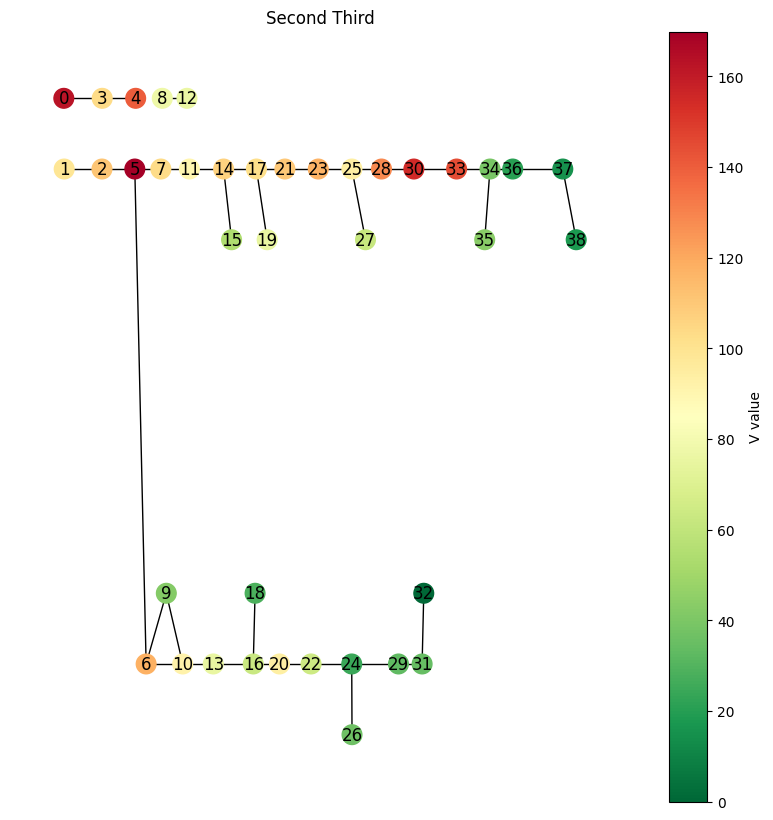

Second Third - Mean V: 80.0341


In [25]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from collections import defaultdict



# Store for all thirds
v_lists = {
    "All": v_list_official,
    "First Third": v_list_official_firstthird,
    "Second Third": v_list_official_secondthird
}

def cluster_graph(G, V_values, nodeidsdict, k=20):
    node_list = list(G.nodes)
    positions = np.array([G.nodes[n]['pos'] for n in G.nodes])
    x_coords, y_coords = positions[:, 0], positions[:, 1]
    sorted_nodes = sorted(zip(node_list, x_coords, y_coords), key=lambda x: x[1])
    
    added_nodes, node_to_group, cluster_groups = set(), {}, defaultdict(list)
    groupid = 0
    for i, (node, x, y) in enumerate(sorted_nodes):
        if node in added_nodes:
            continue
        current_group = [node]
        added_nodes.add(node)
        node_to_group[node] = groupid
        for j in range(i + 1, len(sorted_nodes)):
            next_node, next_x, next_y = sorted_nodes[j]
            if next_y == y and len(current_group) < k and next_node not in added_nodes:
                group_center = np.mean([G.nodes[n]['pos'] for n in current_group], axis=0)
                if np.linalg.norm([next_x - group_center[0], next_y - group_center[1]]) <= 0.5:
                    current_group.append(next_node)
                    added_nodes.add(next_node)
                    node_to_group[next_node] = groupid
                if len(current_group) == k:
                    break
        cluster_groups[groupid].append(current_group)
        groupid += 1

    G_clustered, pos_clustered, v_clustered = nx.Graph(), {}, {}
    for label, groups in cluster_groups.items():
        group = groups[0]
        avg_pos = tuple(np.mean([G.nodes[n]['pos'] for n in group], axis=0))
        nodeidslist = [nodeidsdict[n] for n in group]
        vgroup = V_values[nodeidslist][V_values[nodeidslist] != -420]
        avg_v = np.mean(vgroup) if vgroup.size > 0 else 0
        G_clustered.add_node(label, pos=avg_pos)
        pos_clustered[label] = avg_pos
        v_clustered[label] = avg_v

    added_edges = set()
    for u, v in G.edges:
        u_group, v_group = node_to_group.get(u), node_to_group.get(v)
        if u_group is not None and v_group is not None and u_group != v_group:
            edge = tuple(sorted((u_group, v_group)))
            if edge not in added_edges:
                G_clustered.add_edge(*edge)
                added_edges.add(edge)

    return G_clustered, pos_clustered, v_clustered

def plot_clustered_graph(G_clustered, pos_clustered, v_clustered, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    v = list(v_clustered.values())
    norm = Normalize(vmin=min(v), vmax=max(v))
    cmap = cm.get_cmap('RdYlGn_r')
    colors = [cmap(norm(v_clustered[n])) for n in G_clustered.nodes]
    nx.draw(G_clustered, pos=pos_clustered, node_color=colors, cmap=cmap, with_labels=True, node_size=200, ax=ax)
    sm = ScalarMappable(norm=norm, cmap=cmap)
    plt.colorbar(sm, ax=ax, label='V value')
    ax.set_title(title)
    plt.show()
    print(f"{title} - Mean V: {np.mean(v):.4f}")

results = {}
for label, v_list in v_lists.items():
    Gc, posc, vc = cluster_graph(G, np.array(v_list), nodeidsdict)
    results[label] = (Gc, posc, vc)
    plot_clustered_graph(Gc, posc, vc, label)


In [26]:
node_to_remove = [0, 3, 4, 8, 12]
for label, (Gc, posc, vc) in results.items():
    for node in node_to_remove:
        Gc.remove_node(node)

In [27]:
import datetime
stepsize = 4000
start = 18000
timestamp_eid = np.array([ firstthird, secondthids,  lasteventthird])
conversion = ( 86401 - start ) / len(mean_data[0])
timestamps = [start + int(i * conversion) for i in timestamp_eid]
times = [str(datetime.datetime.fromtimestamp(timestamps[i]).time()) for i in range(len(timestamps))]


Use Station data to create accurate graph

In [28]:
stations_data_coordinates = np.genfromtxt("data/szu_station_coordinates.csv", delimiter=";", skip_header=1, dtype=str)
try: stations_data = np.genfromtxt("data/szu_stations.csv", delimiter=";", dtype=str, skip_header=1)
except:
    df = pd.read_csv("data/szu_stations.csv", encoding='latin1', delimiter=";")
    stations_data = df.to_numpy()

In [29]:
station_names = stations_data_coordinates[:, 0]
station_coords = stations_data_coordinates[:, 1:].astype(float)

{0: 261.8757389011629, 1: 192.34310395204835, 2: 215.8079186873149, 3: 181.0774971538619, 4: 229.88326396476063, 5: 315.6248391783108, 6: 217.2034368472726, 7: 176.57225997450263, 8: 112.13536158354957, 9: 80.44880744643805, 10: 189.45183386285566, 11: 157.62959762182106, 12: 112.33477023405983, 13: 130.24742262573378, 14: 183.45100583680244, 15: 82.62758495293193, 16: 92.70827494561665, 17: 169.03613643833228, 18: 49.91353737145626, 19: 139.42834128950525, 20: 147.04704554538483, 21: 192.33572380928118, 22: 108.5809732412076, 23: 202.3569747536755, 24: 58.646784100502515, 25: 159.06404842517256, 26: 57.0862664450391, 27: 107.98995041967018, 28: 207.543659186757, 29: 79.18298061155834, 30: 270.15033819446825, 31: 81.20659906021591, 32: 4.986515731372401, 33: 244.31508818130598, 34: 75.54796522526047, 35: 76.3647517464072, 36: 45.166442252539646, 37: 33.4005969035056, 38: 24.153451161917566}
{0: 162.75686314517148, 1: 98.73723921450393, 2: 111.47691945202892, 3: 102.98918919981344, 4: 1

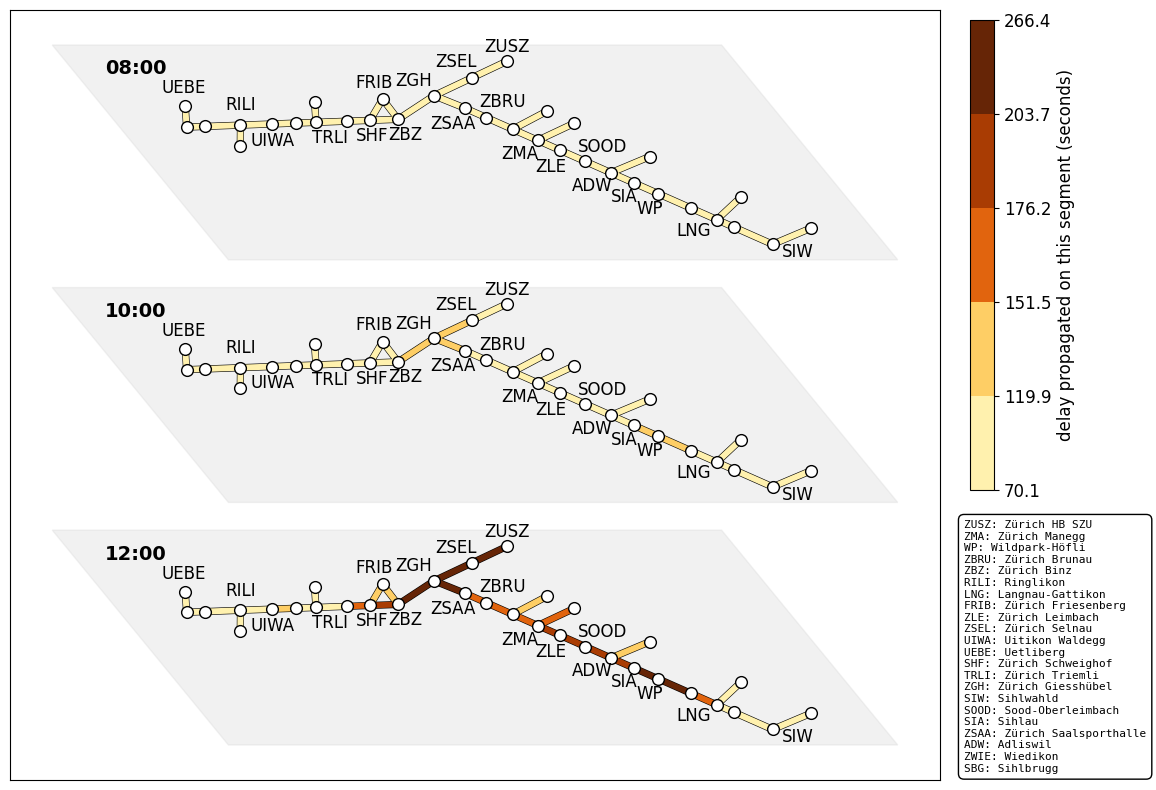

In [ ]:
Gc_all, _, vc_all = results["All"]
Gc_firstthird, _, vc_firstthird = results["First Third"]
Gc_secondthird, _, vc_secondthird = results["Second Third"]

edge_vals = []
for u, v in Gc_all.edges:
    uval = vc_all[u]
    vval = vc_all[v]
    
    avg_value = (uval + vval) / 2
    edge_vals.append(
        avg_value
    )

v_all_vals =edge_vals
norm_fixed = Normalize(vmin=0, vmax=20000)
cmap = cm.RdYlGn_r
fig, ax = plt.subplots(figsize=(12, 10))
total_offset = 0
scaling_y = 0.6

import matplotlib.patches as patches

try: from mapclassify import NaturalBreaks, EqualInterval, Quantiles
except ModuleNotFoundError: 
    !pip install mapclassify
    from mapclassify import NaturalBreaks, EqualInterval, Quantiles
    
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.cm as cm

Gc_all, _, vc_all = results["All"]
edge_vals = np.array(edge_vals)
edge_vals[edge_vals > 25000] = 25000
k=6
nb = NaturalBreaks(edge_vals, k=k)
nb = EqualInterval(edge_vals, k=k)
nb = Quantiles(edge_vals, k=k)

bin_edges = nb.bins
cmap = cm.YlOrBr
segmented_cmap = ListedColormap([cmap((i+1) / k) for i in range(k+1)])
norm_fixed = BoundaryNorm(bin_edges, segmented_cmap.N)
# print(np.max(edge_vals))


for label in ["First Third", "Second Third", "All"][::-1]:
    Gc, _, vc = results[label]
    print(vc)
    positions = {n: Gc.nodes[n]['pos'] for n in Gc.nodes}
    mean_y = np.mean([pos[1] for pos in positions.values()])
    top_arm = [n for n in Gc.nodes if positions[n][1] > mean_y]
    bottom_arm = [n for n in Gc.nodes if positions[n][1] <= mean_y]
    offset_x = -10
    offset_y = 10
    xmorph, ymorph = 0, 0.5
    xmorph2, ymorph2 = 0.5, -3
    xscale = 0.8

    mean_y = np.mean([pos[1] for pos in positions.values()])
    new_positions = {}

    for node in Gc.nodes:
        y, x = positions[node][1], positions[node][0]
        if y <= mean_y:  # bottom_arm
            tx = (-x * 1 + 1.5 * xmorph * y) * xscale + offset_x
            ty = (5 * y + 0.5 * ymorph * -x + 22) * scaling_y + total_offset + offset_y
        else:  # top_arm
            tx = (1 - 2 * xmorph2 * y + x * 1 + 6) * xscale + offset_x
            ty = (35 + ymorph2 * x) * scaling_y + total_offset + offset_y
        new_positions[node] = (tx, ty)

    edge_colors = []
    edge_colors = []
    for u, v in Gc.edges:
        uval = vc[u]
        vval = vc[v]
        avg_value = (uval + vval) / 2
        edge_colors.append(segmented_cmap(norm_fixed(avg_value)))
    node_ids = list(Gc.nodes)
    new_positions[1] = new_positions[1][0] + 3.3, new_positions[1][1] +2
    new_positions[2] = new_positions[2][0] + 1.5, new_positions[2][1] +1.5
    new_positions[5] = new_positions[5][0] -0.3, new_positions[5][1] +0.5
    for node in [15, 19, 27, 35, 38]:
        new_positions[node] = new_positions[node][0] , new_positions[node][1] + 3

    nx.draw_networkx_edges(Gc, pos=new_positions, ax=ax, width=18/7*2, alpha=1, edge_color='black')
    nx.draw_networkx_edges(Gc, pos=new_positions, ax=ax, width=15/7*2, alpha=1, edge_color=edge_colors)
    nx.draw_networkx_nodes(Gc, pos=new_positions, ax=ax, node_size=250/7*2, node_color="white", cmap=cmap, edgecolors="black", linewidths=1, label=node_ids)

    manual_index_offsets = {
    0: (4, 1.4),   # ZUSZ
    1: (1.9, 0.8),   # ZSEL
    2: (-0.3, 0.2),  # ZGH
    3: (0.2, -4.5),  # ZSAA
    4: (1.0, 0.0),   # ZBRU
    5: (-0.35, -4.5),  # ZMA
    6: (-0.2, -5.4),  # ZLE
    15: (0.2, -4.6),  # SHF
    19: (0.0, 2.0),  # UEBE
    13: (0.2, 0-4.6),  # ZBZ
    17: (0.0, -4.5),  # UIWA
    18: (0.0, 2.0),  # RILI
    16: (-0.5, -4.5),  # TRLI
    14: (0.0, 3.3),  # FRIB
    }
    label_offsets = {
        # You can add more here by station name if needed
        'SIA': (-0.35-0.3, -3.3),
        'SOOD': (0.25, 0.5),
        "ADW": (-0.8-0.3, -3.6),
        "WP": (-0.5-0.3, -3),
        "LNG": (-0.7-0.25, -4),
        "SIW": (-0, -2.5),
    }

    for idx, (name, (x, y)) in enumerate(zip(station_names, station_coords)):
        if y <= mean_y:
            tx = (-x * 1 + 1.5 * xmorph * y) * xscale + offset_x
            ty = (5 * y + 0.5 * ymorph * -x + 22) * scaling_y + total_offset + offset_y
        else:
            tx = (1 - 2 * xmorph2 * y + x * 1 + 6) * xscale + offset_x
            ty = (35 + ymorph2 * x) * scaling_y + total_offset + offset_y
        
        dx, dy = manual_index_offsets.get(idx, (0, 0))
        if name in label_offsets:
            dx, dy = label_offsets[name]
        
        ax.text(tx + dx, ty + dy + 0.8, name, fontsize=12, ha='center', va='bottom', zorder=10)
    total_offset += 35

# Draw overlays first
plane_height = 30
slope = -0.3
width = 19
xoffset = -16
spacing = 35
topy = 91.7
plane_centers = [topy - spacing*2, topy - spacing, topy]
for i, center in enumerate(plane_centers):
    y0 = center - plane_height // 2
    rect = patches.Polygon(
        [[xoffset, y0-1], 
        [xoffset + width, y0-1], 
        [xoffset + width - 5, y0 + plane_height], 
        [xoffset - 5, y0 + plane_height]],

        closed=True,
        color='lightgrey',
        alpha=0.3,
        zorder=0
    )
    ax.add_patch(rect)
    axloc = xoffset - 3.5, center + plane_height / 2.6
    ax.text(axloc[0], axloc[1], f"{['12:00', '10:00', '08:00'][i]}", fontsize=14, color='black', va='center', weight='bold')


sm = ScalarMappable(norm=norm_fixed, cmap=segmented_cmap)

cb_width = 0.05
cb_ax = fig.add_axes([0.925,1-(0.11+0.45)-0.04,0.02,0.47])
cbar = fig.colorbar(sm, cax=cb_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=12)  # Set the font size of colorbar ticks
cbar.set_label('delay propagated on this segment (seconds)', fontsize=12)
ax.set_xticks([])
ax.set_yticks([])



from matplotlib.offsetbox import AnchoredText

legend_entries = []
for row in stations_data:
    code = row[1]
    full_name = row[2]
    legend_entries.append(f"{code}: {full_name}")
legend_text = "\n".join(legend_entries)

# Add text box in figure coordinates (adjust x/y as needed)
fig.text(
    0.92,           # x position (near colorbar)
    0.37,            # y center
    legend_text,
    ha='left',
    va='top',
    fontsize=8,
    family='monospace',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)
plt.show()


[204.07551131968162, 265.71637893281286, 266.4141380127917, 246.09854957640673, 148.8261221468553, 203.32763535506413, 167.10092879816185, 134.95032065464687, 159.8496282442947, 170.54030172931175, 111.4778487856752, 133.03929539486717, 176.24357113756736, 71.31090615853645, 119.87766024550075, 154.23223886391878, 180.6859301238067, 127.81400939329622, 197.34634928147835, 83.61387867085506, 180.71051158942402, 57.86652527277081, 68.91488235603043, 133.52699942242137, 183.30385380596476, 238.84699869061262, 80.19478983588712, 257.2327131878871, 43.09655739579416, 159.93152670328323, 75.95635848583383, 60.357203738900054, 39.28351957802262, 28.777024032711584]
{0: 261.8757389011629, 1: 192.34310395204835, 2: 215.8079186873149, 3: 181.0774971538619, 4: 229.88326396476063, 5: 315.6248391783108, 6: 217.2034368472726, 7: 176.57225997450263, 8: 112.13536158354957, 9: 80.44880744643805, 10: 189.45183386285566, 11: 157.62959762182106, 12: 112.33477023405983, 13: 130.24742262573378, 14: 183.4510

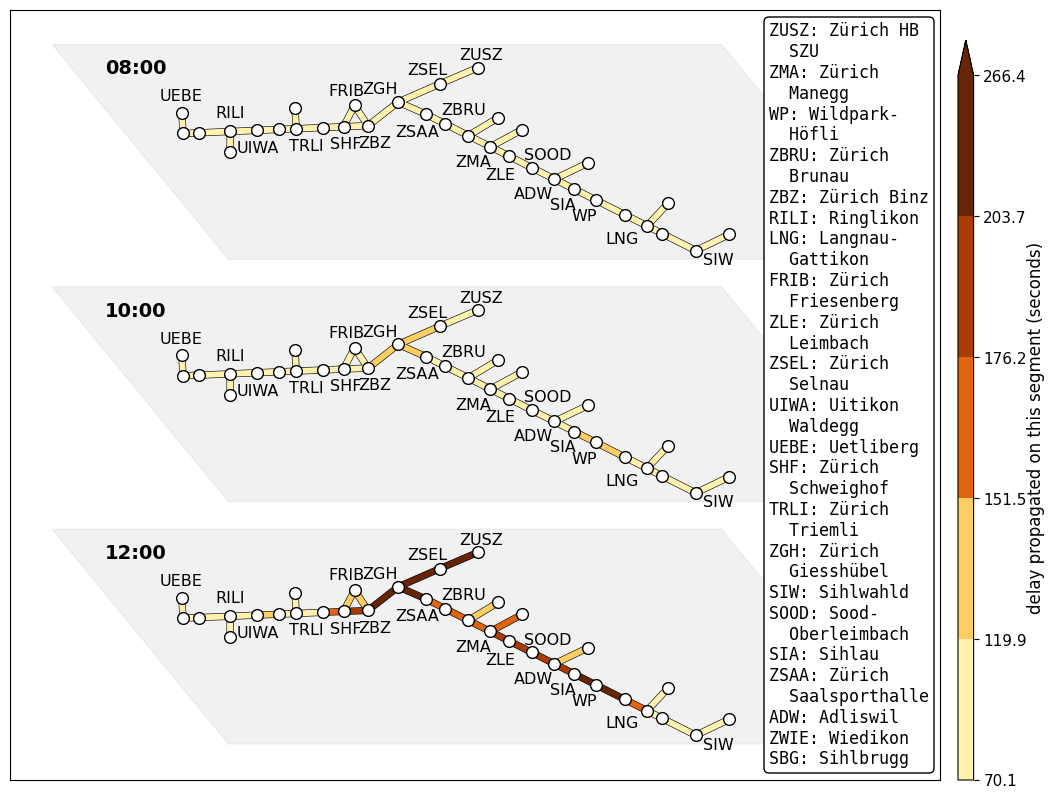

In [ ]:
Gc_all, _, vc_all = results["All"]
Gc_firstthird, _, vc_firstthird = results["First Third"]
Gc_secondthird, _, vc_secondthird = results["Second Third"]

edge_vals = []
for u, v in Gc_all.edges:
    uval = vc_all[u]
    vval = vc_all[v]
    
    avg_value = (uval + vval) / 2
    edge_vals.append(
        avg_value
    )

v_all_vals =edge_vals
print(edge_vals)
# norm_fixed = Normalize(vmin=min(v_all_vals), vmax=max(v_all_vals))
norm_fixed = Normalize(vmin=0, vmax=20000)
cmap = cm.RdYlGn_r
# Plot all stacked using fixed v_map from "All"
fig, ax = plt.subplots(figsize=(12, 10))
total_offset = 0
scaling_y = 0.6

import matplotlib.patches as patches
# Define overlay parameters



# Replace cmap and color attribution
from mapclassify import NaturalBreaks, EqualInterval, Quantiles, FisherJenks, MaximumBreaks, StdMean,HeadTailBreaks,JenksCaspall,JenksCaspallForced,JenksCaspallSampled,UserDefined
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.cm as cm

# Compute natural breaks from the "All" edge values
Gc_all, _, vc_all = results["All"]
# edge_vals = [(vc_all[u] + vc_all[v]) / 2 for u, v in Gc_all.edges]
edge_vals = np.array(edge_vals)
edge_vals[edge_vals > 25000] = 25000
k=6
nb = NaturalBreaks(edge_vals, k=k)
nb = EqualInterval(edge_vals, k=k)
nb = Quantiles(edge_vals, k=k) # I LIKE THIS

bin_edges = nb.bins
cmap = cm.YlOrBr
segmented_cmap = ListedColormap([cmap((i+1) / k) for i in range(k+1)])
norm_fixed = BoundaryNorm(bin_edges, segmented_cmap.N)


for label in ["First Third", "Second Third", "All"][::-1]:
    Gc, _, vc = results[label]
    print(vc)
    positions = {n: Gc.nodes[n]['pos'] for n in Gc.nodes}
    mean_y = np.mean([pos[1] for pos in positions.values()])
    top_arm = [n for n in Gc.nodes if positions[n][1] > mean_y]
    bottom_arm = [n for n in Gc.nodes if positions[n][1] <= mean_y]
    offset_x = -11
    offset_y = 9
    xmorph, ymorph = 0, 0.5
    xmorph2, ymorph2 = 0.5, -3
    xscale = 0.7

    mean_y = np.mean([pos[1] for pos in positions.values()])
    new_positions = {}

    for node in Gc.nodes:
        y, x = positions[node][1], positions[node][0]
        if y <= mean_y:  # bottom_arm
            tx = (-x * 1 + 1.5 * xmorph * y) * xscale + offset_x
            ty = (5 * y + 0.5 * ymorph * -x + 22) * scaling_y + total_offset + offset_y
        else:  # top_arm
            tx = (1 - 2 * xmorph2 * y + x * 1 + 6) * xscale + offset_x
            ty = (35 + ymorph2 * x) * scaling_y + total_offset + offset_y
        new_positions[node] = (tx, ty)

    edge_colors = []
    edge_colors = []
    for u, v in Gc.edges:
        uval = vc[u]
        vval = vc[v]
        avg_value = (uval + vval) / 2
        edge_colors.append(segmented_cmap(norm_fixed(avg_value)))
    node_ids = list(Gc.nodes)
    new_positions[1] = new_positions[1][0] + 3.3, new_positions[1][1] +2
    new_positions[2] = new_positions[2][0] + 1.5, new_positions[2][1] +1.5
    new_positions[5] = new_positions[5][0] -0.3, new_positions[5][1] +0.5
    for node in [15, 19, 27, 35, 38]:
        new_positions[node] = new_positions[node][0] , new_positions[node][1] + 3

    nx.draw_networkx_edges(Gc, pos=new_positions, ax=ax, width=18/7*2, alpha=1, edge_color='black')
    nx.draw_networkx_edges(Gc, pos=new_positions, ax=ax, width=15/7*2, alpha=1, edge_color=edge_colors)
    nx.draw_networkx_nodes(Gc, pos=new_positions, ax=ax, node_size=250/7*2, node_color="white", cmap=cmap, edgecolors="black", linewidths=1, label=node_ids)

    manual_index_offsets = {
    0: (4, 1.4),   # ZUSZ
    1: (1.9, 0.8),   # ZSEL
    2: (-0.3, 0.2),  # ZGH
    3: (0.2, -4.5),  # ZSAA
    4: (1.0, 0.0),   # ZBRU
    5: (-0.35, -4.5),  # ZMA
    6: (-0.2, -5.4),  # ZLE
    15: (0.2, -4.6),  # SHF
    19: (0.0, 2.0),  # UEBE
    13: (0.2, 0-4.6),  # ZBZ
    17: (0.0, -4.5),  # UIWA
    18: (0.0, 2.0),  # RILI
    16: (-0.5, -4.5),  # TRLI
    14: (0.0, 3.3),  # FRIB
    }
    label_offsets = {
        # You can add more here by station name if needed
        'SIA': (-0.35-0.3, -3.3),
        'SOOD': (0.25, 0.5),
        "ADW": (-0.8-0.3, -3.6),
        "WP": (-0.5-0.3, -3),
        "LNG": (-0.7-0.25, -4),
        "SIW": (-0, -2.5),
    }
    node_station_pos = {}
    for idx, (name, (x, y)) in enumerate(zip(station_names, station_coords)):
        if y <= mean_y:
            tx = (-x * 1 + 1.5 * xmorph * y) * xscale + offset_x
            ty = (5 * y + 0.5 * ymorph * -x + 22) * scaling_y + total_offset + offset_y
        else:
            tx = (1 - 2 * xmorph2 * y + x * 1 + 6) * xscale + offset_x
            ty = (35 + ymorph2 * x) * scaling_y + total_offset + offset_y
        
        dx, dy = manual_index_offsets.get(idx, (0, 0))
        if name in label_offsets:
            dx, dy = label_offsets[name]
        
        ax.text(tx + dx, ty + dy + 0.8, name, fontsize=11.5, ha='center', va='bottom', zorder=10)
        node_station_pos[name] = (tx + dx, ty + dy + 0.8)

    total_offset += 35

# Draw overlays first
plane_height = 30
slope = -0.3
width = 19
xoffset = -16
spacing = 35
topy = 91.7

plane_centers = [topy - spacing*2, topy - spacing, topy]
textlocs = {}
for i, center in enumerate(plane_centers):
    y0 = center - plane_height // 2
    rect = patches.Polygon(
        [[xoffset, y0-1], 
        [xoffset + width, y0-1], 
        [xoffset + width - 5, y0 + plane_height], 
        [xoffset - 5, y0 + plane_height]],

        closed=True,
        color='lightgrey',
        alpha=0.3,
        zorder=0
    )
    ax.add_patch(rect)
    axloc = xoffset - 3.5, center + plane_height / 2.6

    ax.text(axloc[0], axloc[1], f"{['12:00', '10:00', '08:00'][i]}", fontsize=14, color='black', va='center', weight='bold')


sm = ScalarMappable(norm=norm_fixed, cmap=segmented_cmap)

cb_width = 0.05
# cb_ax = fig.add_axes([0.14,0.08,0.745,0.016])
# cbar = fig.colorbar(sm, cax=cb_ax, orientation='horizontal')
cb_ax = fig.add_axes([0.915,0.1095,0.013,0.74])
cbar = fig.colorbar(sm, cax=cb_ax, orientation='vertical',extend='max')
cbar.ax.tick_params(labelsize=11)  # Set the font size of colorbar ticks
cbar.set_label('delay propagated on this segment (seconds)', fontsize=12, labelpad=0)
ax.set_xticks([])
ax.set_yticks([])

# plt.tight_layout()

from matplotlib.offsetbox import AnchoredText
import re

def smart_wrap(text, width):
    parts = re.split(r'([ -])', text)  # split at spaces and dashes, keeping delimiters
    lines = []
    line = ""
    for part in parts:
        if len(line + part) > width:
            lines.append(line.rstrip())
            line = "  " + part  # indent wrapped lines
        else:
            line += part
    lines.append(line.rstrip())
    return "\n".join(lines)

legend_entries = []
wrap_width = 11

for row in stations_data:
    code = row[1]
    full_name = row[2]
    wrapped = smart_wrap(full_name, wrap_width)
    legend_entries.append(f"{code}: {wrapped}")

legend_text = "\n".join(legend_entries)

fig.text(
    0.7575,
    0.8675,
    legend_text,
    ha='left',
    va='top',
    fontsize=12,
    family='monospace',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)


# plt.tight_layout()
plt.savefig("figures/stacked_heatmap.pdf", dpi=600, bbox_inches='tight')
plt.show()
old_new_positions = new_positions   

In [32]:
cluster_nodes = [9, 18, 19, 27, 35, 21, 34, 37, 14, 15]
def merge_cluster_nodes_after_clustering(G, pos, v, nodes_to_merge):
    G_new = G.copy()
    pos_new = pos.copy()
    v_new = v.copy()
    nodes_to_merge = [node for node in nodes_to_merge if node in G.nodes()]
    for node in nodes_to_merge:
        neighbors = list(G_new.neighbors(node))
        if not neighbors:
            continue
        target = neighbors[0]  # choose first neighbor (assume leaf or terminal)

        # average value
        v_new[target] = (v_new[target] + v_new[node]) / 2
        # weighted average position (optional: just use center)
        p1, p2 = np.array(pos_new[target]), np.array(pos_new[node])
        pos_new[target] = tuple((p1 + p2) / 2)

        # reconnect other edges to target
        for neighbor in G_new.neighbors(node):
            if neighbor != target and not G_new.has_edge(neighbor, target):
                G_new.add_edge(neighbor, target)

        # remove node
        G_new.remove_node(node)
        v_new.pop(node, None)
        pos_new.pop(node, None)

    return G_new, pos_new, v_new

# Gc_merged, pos_merged, vc_merged = merge_cluster_nodes_after_clustering(Gc, pos_clustered, v_clustered, to_merge)

Use data from infographic to create similar looking map

In [33]:
station_to_node = {
    "Zürich HB SZU": 1,
    'Selnau': 2, 
    'Giesshübel': 5, 
    'Saalsporthalle': 7, 
    'Brunau': 11, 
    'Manegg': 17, 
    'Leimbach': 23, 
    'Sood-Oberleimbach': 25, 
    'Adliswil': 28, 
    'Sihlau': 30, 
    'Wildpark-Höfli': 33, 
    'Langnau-Gattikon': 36, 
    'Sihlwahld': 38, 
    'Binz': 6, 
    'Friesenberg': 10, 
    'Schweighof': 13, 
    'Triemli': 20, 
    'Uitikon:':24,
    'Waldegg': 24, 
    'Ringlikon': 29, 
    'Uetliberg': 32
    }

In [34]:
stationposrot = {
    "Zürich HB SZU": (0,0),
    'Selnau': (0,0),
    'Giesshübel': (0,0),
    'Saalsporthalle': (0,0),
    'Brunau':(0,0),
    'Manegg': (0,0),
    'Leimbach': (0,0),
    'Sood-Oberleimbach': (0,0),
    'Adliswil': (0,0),
    'Sihlau': (0,0),
    'Wildpark-Höfli': (0,0),
    'Langnau-Gattikon': (0,0),
    'Sihlwahld': (0,0),
    'Binz': (45,0),
    'Friesenberg':(45,0),
    'Schweighof': (45,0),
    'Triemli': (45,0),
    'Uitikon': (0,0),
    'Waldegg': (0,0),
    'Ringlikon': (0,0),
    'Uetliberg': (0,0),
    }
lowerrightarmaddx = +0.7
lowerrightarmaddy = -1.2

upperleftarmaddx = -1
upperleftarmaddy = -2.5
upperleftarmbasex = -13.036
newnewpositions = {
    1: (-8.924, 103.347),
    2: (-9.505, 100.997),
    5: (-11.180, 96.390),
    7: (-11.884, 93.615),
    11: (-11.240, 91.218),
    14: (-11.237+ lowerrightarmaddx*0.5,  91.218+ lowerrightarmaddy*0.5),
    15: (-11.237+ lowerrightarmaddx, 91.153+ lowerrightarmaddy),
    17: (-11.237+ lowerrightarmaddx*1,  91.218+ lowerrightarmaddy*1),
    19: (-7.660, 94.412),
    21: (-11.237+ lowerrightarmaddx*2.5,  91.218+ lowerrightarmaddy*2.5),
    23: (-11.237+ lowerrightarmaddx*2,  91.218+ lowerrightarmaddy*2),
    25: (-11.237+ lowerrightarmaddx*3,  91.218+ lowerrightarmaddy*3),
    27: (-5.788, 89.598),
    28: (-11.237+ lowerrightarmaddx*4,  91.218+ lowerrightarmaddy*4),
    30: (-11.237+ lowerrightarmaddx*5,  91.218+ lowerrightarmaddy*5),
    33: (-11.237+ lowerrightarmaddx*6,  91.218+ lowerrightarmaddy*6),
    34: (-11.237+ lowerrightarmaddx*7.5,  91.218+ lowerrightarmaddy*7.5),
    35: (-3.519, 83.763),
    36: (-11.237+ lowerrightarmaddx*7,  91.218+ lowerrightarmaddy*7),
    37: (-11.237+ lowerrightarmaddx*8,  91.218+ lowerrightarmaddy*8),
    38: (-11.237+ lowerrightarmaddx*8,  91.218+ lowerrightarmaddy*8),
    6: (upperleftarmbasex, 94.978),
    9: (-12.420, 97.896),
    10: (upperleftarmbasex+upperleftarmaddx*1, 94.978+upperleftarmaddy*0),
    13: (upperleftarmbasex+upperleftarmaddx*2, 94.978+upperleftarmaddy*0),
    16: (upperleftarmbasex+upperleftarmaddx*3, 94.978+upperleftarmaddy*0),
    18: (-14.110, 97.534),
    20: (upperleftarmbasex+upperleftarmaddx*3, 94.978+upperleftarmaddy*0),
    22: (upperleftarmbasex+upperleftarmaddx*4, 94.978+upperleftarmaddy*0),
    24: (upperleftarmbasex+upperleftarmaddx*4, 94.978+upperleftarmaddy*0), # 24 waldegg
    26: (upperleftarmbasex+upperleftarmaddx*4.5, 94.978+upperleftarmaddy*1), # 26 DUMMY
    29: (upperleftarmbasex+upperleftarmaddx*4, 94.978+upperleftarmaddy*0.75), # 29 ringlikon
    31: (upperleftarmbasex+upperleftarmaddx*4, 94.978+upperleftarmaddy*1.5),
    32: (upperleftarmbasex+upperleftarmaddx*4, 94.978+upperleftarmaddy*1.5),
}

In [35]:
ystandardlower = 0.4
ystandardlower2 = 0.6
ystandardupper = -0.35
xstandardupper = 0.7
xstandardlower2 = 0
stationposdelta = {
    "Zürich HB SZU": (-1.2,-ystandardlower),
    'Selnau': (+0.7,-ystandardlower),
    'Giesshübel': (+1.0,-ystandardlower),
    'Saalsporthalle': (-1.2+xstandardlower2,-ystandardlower2),
    'Brunau': (-0.75+xstandardlower2,-ystandardlower2),
    'Manegg': (-0.8+xstandardlower2,-ystandardlower2),
    'Leimbach': (-0.9+xstandardlower2,-ystandardlower2-0.05),
    'Sood-Oberleimbach': (-1.55+xstandardlower2,-ystandardlower2),
    'Adliswil': (-0.8+xstandardlower2,-ystandardlower2),
    'Sihlau': (-0.7+xstandardlower2,-ystandardlower2),
    'Wildpark-Höfli': (-1.25+xstandardlower2,-ystandardlower2),
    'Langnau-Gattikon': (-1.4+xstandardlower2,-ystandardlower2), 
    'Sihlwahld': (-0.9+xstandardlower2,-ystandardlower2),
    'Binz': (xstandardupper-0.35,-ystandardupper+0.05),
    'Friesenberg': (xstandardupper,-ystandardupper),
    'Schweighof': (xstandardupper-0.05,-ystandardupper),
    'Triemli': (xstandardupper-0.25,-ystandardupper),
    'Uitikon': (-1.3,-ystandardupper),
    'Waldegg': (-1.3,-ystandardupper),
    'Ringlikon': (-0.8,-0.3), 
    'Uetliberg': (+0.85,-0.35),
    }

In [36]:
normalized_station_positions = {
    'Zürich HB': (515/832,  42/832),
    'Selnau': (568/832,  92/832),
    'Giesshübel': (614/832, 138/832),
    'Saalsporthalle': (520/832, 177/832),
    'Binz': (450/832, 180/832),
    'Friesenberg': (432/832, 212/832),
    'Schweighof': (415/832, 244/832),
    'Triemli': (387/832, 273/832),
    'Uitikon Waldegg': (356/832, 305/832),
    'Ringlikon': (331/832, 335/832),
    'Uetliberg': (293/832, 365/832),

    'Brunau': (580/832, 183/832),
    'Manegg': (618/832, 222/832),
    'Leimbach': (648/832, 257/832),
    'Sood-Oberleimbach': (677/832, 292/832),
    'Adliswil': (702/832, 328/832),
    'Sihlau': (725/832, 358/832),
    'Wildpark-Höfli': (749/832, 392/832),
    'Langnau-Gattikon': (773/832, 425/832),
    'Sihlwald': (797/832, 457/832),
}
guessed_node_positions = {
    'ZUSZ': (515/832,  42/832),   # Zürich HB SZU
    'ZSEL': (568/832,  92/832),   # Zürich Selnau
    'ZGH':  (614/832, 138/832),   # Zürich Giesshübel
    'ZSAA': (520/832, 177/832),   # Zürich Saalsporthalle
    'ZBZ':  (450/832, 180/832),   # Zürich Binz
    'FRIB': (432/832, 212/832),   # Zürich Friesenberg
    'SHF':  (415/832, 244/832),   # Zürich Schweighof
    'TRLI': (387/832, 273/832),   # Zürich Triemli
    'UIWA': (356/832, 305/832),   # Uitikon Waldegg
    'RILI': (331/832, 335/832),   # Ringlikon
    'UEBE': (293/832, 365/832),   # Uetliberg

    'ZBRU': (580/832, 183/832),   # Zürich Brunau
    'ZMA':  (618/832, 222/832),   # Zürich Manegg
    'ZLE':  (648/832, 257/832),   # Zürich Leimbach
    'SOOD': (677/832, 292/832),   # Sood-Oberleimbach
    'ADW':  (702/832, 328/832),   # Adliswil
    'SIA':  (725/832, 358/832),   # Sihlau
    'WP':   (749/832, 392/832),   # Wildpark-Höfli
    'LNG':  (773/832, 425/832),   # Langnau-Gattikon
    'SIW':  (797/832, 457/832),   # Sihlwald
}


In [37]:
code_to_node = {}
node_to_code = {}

available_nodes = node_station_pos.copy()

for code, guess_pos in guessed_node_positions.items():
    distances = {
        node: np.linalg.norm(np.array(guess_pos) - np.array(pos))
        for node, pos in available_nodes.items()
    }
    closest_node = min(distances, key=distances.get)
    code_to_node[code] = closest_node
    node_to_code[closest_node] = code
    del available_nodes[closest_node]  # prevent reuse
print(code_to_node)
print(node_to_code)

{'ZUSZ': 'SIW', 'ZSEL': 'LNG', 'ZGH': 'WP', 'ZSAA': 'SIA', 'ZBZ': 'ADW', 'FRIB': 'ZLE', 'SHF': 'ZMA', 'TRLI': 'SOOD', 'UIWA': 'UIWA', 'RILI': 'TRLI', 'UEBE': 'SHF', 'ZBRU': 'ZBZ', 'ZMA': 'ZSAA', 'ZLE': 'ZBRU', 'SOOD': 'RILI', 'ADW': 'UEBE', 'SIA': 'FRIB', 'WP': 'ZGH', 'LNG': 'ZSEL', 'SIW': 'ZUSZ'}
{'SIW': 'ZUSZ', 'LNG': 'ZSEL', 'WP': 'ZGH', 'SIA': 'ZSAA', 'ADW': 'ZBZ', 'ZLE': 'FRIB', 'ZMA': 'SHF', 'SOOD': 'TRLI', 'UIWA': 'UIWA', 'TRLI': 'RILI', 'SHF': 'UEBE', 'ZBZ': 'ZBRU', 'ZSAA': 'ZMA', 'ZBRU': 'ZLE', 'RILI': 'SOOD', 'UEBE': 'ADW', 'FRIB': 'SIA', 'ZGH': 'WP', 'ZSEL': 'LNG', 'ZUSZ': 'SIW'}


Plot Graph!

In [ ]:
def generate_network_plot(results, 
                          node_station_pos, 
                          all_node_positions, 
                          stations_data, 
                          station_to_node, 
                          station_pos, 
                          stationposrot, 
                          ytilt,
                          xtilt,
                          rotangledeg,
                          save_path="figures/stacked_heatmap.png"):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import networkx as nx
    import numpy as np
    from matplotlib.cm import YlOrBr
    from matplotlib.colors import BoundaryNorm, ListedColormap, Normalize
    from matplotlib.cm import ScalarMappable
    from mapclassify import Quantiles

    Gc_all, _, vc_all = results["All"]
    all_node_positionsfn = {}
    xlist = []
    for k in all_node_positions:
        x, y = all_node_positions[k]
        all_node_positionsfn[k] = (x, y * ytilt)
        xlist.append(x)
    scalelengthx = np.abs(np.max(xlist) - np.min(xlist))
    middlenode = 11
    xmiddle = all_node_positions[middlenode][0]
    xdrift = xmiddle - 5
    xlist = []
    for k in all_node_positions:
        x, y = all_node_positions[k]
        all_node_positionsfn[k] = (x - (x-xmiddle)*(1-xtilt), y * ytilt)
        xlist.append(x)
    scalelengthx = np.abs(np.max(xlist) - np.min(xlist))

    # Gc_all, _, vc_all = results["All"]
    # all_node_positionsfn = {}

    # Rotation center
    cx, cy = all_node_positions[11]
    theta = np.deg2rad(rotangledeg)  # specify angle in degrees

    # Rotation matrix
    R = np.array([[np.cos(theta), -np.sin(theta)],
                [np.sin(theta),  np.cos(theta)]])

    for k, (x, y) in all_node_positions.items():
        v = np.array([x - cx, y - cy])
        v_rot = R @ v
        all_node_positionsfn[k] = (v_rot[0] + cx, v_rot[1] + cy)
    xlist = []
    ylist = []
    for k in all_node_positions:
        x, y = all_node_positionsfn[k]
        all_node_positionsfn[k] = (x*xtilt, y * ytilt)
        xlist.append(x)
        ylist.append(y)
    scalelengthx = np.abs(np.max(xlist) - np.min(xlist))
    scalelengthy = np.abs(np.max(ylist) - np.min(ylist))
    minx = np.min(xlist)
    miny = np.min(ylist)

    edge_vals = [
        (vc_all[u] + vc_all[v]) / 2
        for u, v in Gc_all.edges
    ]
    edge_vals = np.array(edge_vals)
    edge_vals[edge_vals > 25000] = 25000

    k = 6
    nb = Quantiles(edge_vals, k=k)
    bin_edges = nb.bins
    cmap = YlOrBr
    segmented_cmap = ListedColormap([cmap((i+1) / k) for i in range(k+1)])
    norm_fixed = BoundaryNorm(bin_edges, segmented_cmap.N)


    # FFFFFFFFFFFFFFFFFFIIIIIG
    fig, ax = plt.subplots(figsize=(8, 9))
    total_offset = 0
    code_to_fullname = {
    row[1]: row[2].replace("Zürich ", "") if row[2] != "Zürich HB SZU" else row[2]
    for row in stations_data}
    
    
    to_merge = [9, 18, 19, 22, 27, 35, 21,31, 34, 37, 14, 15, 16, 26]  # cluster node IDs from result
    # to_merge = [0]
    for i, label in enumerate(["First Third", "Second Third", "All"][::-1]):
        Gc, _, vc = results[label]
        Gc_merged, pos_merged, vc_merged = merge_cluster_nodes_after_clustering(Gc, _, vc, to_merge)
        Gc, _, vc = Gc_merged, pos_merged, vc_merged 
        new_positions = {n: all_node_positionsfn[n] for n in Gc.nodes if n in all_node_positionsfn}
        for node in Gc.nodes:
            pos = all_node_positionsfn[node]
            pos = pos[0], (pos[1] + total_offset) 
            new_positions[node] = pos
        
        for name, pos in node_station_pos.items():
            poscorry = 1
            poscorrx = 1.22
            if name in code_to_fullname:
                name = code_to_fullname[name]

                if name == 'Uitikon Waldegg' or name == 'Waldegg':
                    node = 24
                    rot = 0
                    pos = new_positions[24]
                    # ax.text(pos[0]-0.8*poscorrx*xtilt, (pos[1]+0.2*poscorry), "Uitikon", fontsize=11.5, ha='center', va='bottom', zorder=10, rotation=rot)
                    # ax.text(pos[0]-0.8*poscorrx*xtilt, (pos[1]-0.55*poscorry), "Waldegg-", fontsize=11.5, ha='center', va='bottom', zorder=10, rotation=rot)
                else:
                    node = station_to_node[name]
                    if node in [1,5,32,38]:
                        rot = stationposrot[name][0]
                        pos = new_positions[node]
                        poss = [(0,0),(0,0),(0,0),(0,0)]
                        if name == "Zürich HB SZU":
                            txt = "Zürich HB"
                        else:
                            txt = name
                        pos =  pos[0] + station_pos[name][0]*poscorrx,pos[1]+station_pos[name][1]*ytilt*poscorry
                        ax.text(pos[0], pos[1], txt, fontsize=14, ha='center', va='bottom', zorder=10, rotation=rot)
                        # ax.annotate(name, xy=(pos[0], pos[1]), xytext=(pos[0], pos[1]), 
                        #             fontsize=14, ha='center', va='bottom', zorder=10, 
                        #             arrowprops=dict(arrowstyle='->', lw=1.5, color='black'), rotation=rot)
        # Draw overlays first
        plane_height = (scalelengthy/2+2.2)*ytilt
        width = (scalelengthx+0.8) / 2 * xtilt
        xoffset = minx + scalelengthx/2 -2
        scalelengthx *= (1)
       
        # spacing = 3 *ytilt
        yoffset = miny + scalelengthy/2
        paralellox = scalelengthx *2*-np.sin(np.deg2rad(rotangledeg))
        # lowest_y = all_node_positions[38][1] * ytilt + yoffset
        # topy = 142.5 

        plane_center = (yoffset +total_offset) 
        textlocs = {}
        y0 = plane_center + plane_height
        rect = patches.Polygon(
            [[xoffset-width+paralellox, y0], 
            [xoffset + width+paralellox, y0], 
            [xoffset + width, y0 - 2*plane_height], 
            [xoffset-width, y0 - 2*plane_height]],

            closed=True,
            color='lightgrey',
            alpha=0.3,
            zorder=0
        )
        ax.add_patch(rect)
        axloc = xoffset-width*0.8 , plane_center - plane_height /1.25

        ax.text(axloc[0], axloc[1], f"{['12:00', '10:00', '08:00'][i]}", fontsize=18, color='black', va='center', weight='bold')
        
        edge_colors = []
        for u, v in Gc.edges:
            avg_value = (vc[u] + vc[v]) / 2
            edge_colors.append(segmented_cmap(norm_fixed(avg_value)))
        nodeids = list(Gc.nodes)
        for node in nodeids:
            if node not in all_node_positions:
                Gc.remove_node(node)
        nx.draw_networkx_edges(Gc, pos=new_positions, ax=ax, width=18/7*3, alpha=1, edge_color='black')
        nx.draw_networkx_edges(Gc, pos=new_positions, ax=ax, width=15/7*3, alpha=1, edge_color=edge_colors)
        nx.draw_networkx_nodes(Gc, pos=new_positions, ax=ax, node_size=250/7*2, node_color="white", cmap=cmap, edgecolors="black", linewidths=1)#, label=nodeids)
        # nx.draw_networkx_labels(Gc, pos=new_positions, ax=ax, labels={n: str(n) for n in Gc.nodes}, font_size=12)
        total_offset += 30* ytilt
    
    # Draw colorbar
    sm = ScalarMappable(norm=norm_fixed, cmap=segmented_cmap)
    cb_ax = fig.add_axes([0.915, 0.135, 0.0175, 0.72])
    cbar = fig.colorbar(sm, cax=cb_ax, orientation='vertical', extend='max')
    cbar.ax.tick_params(labelsize=11)
    cbar.set_label('total secondary delay on segment (seconds)', fontsize=14, labelpad=0)
    # ax.add_patch(patches.Rectangle(
    #     (-20, 95),  # bottom left
    #     width=1,
    #     height=0.001,
    #     linewidth=0,
    #     edgecolor="r",
    #     facecolor='r',
    #     alpha=0.0,  # invisible
    #     zorder=0
    #     ))
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])



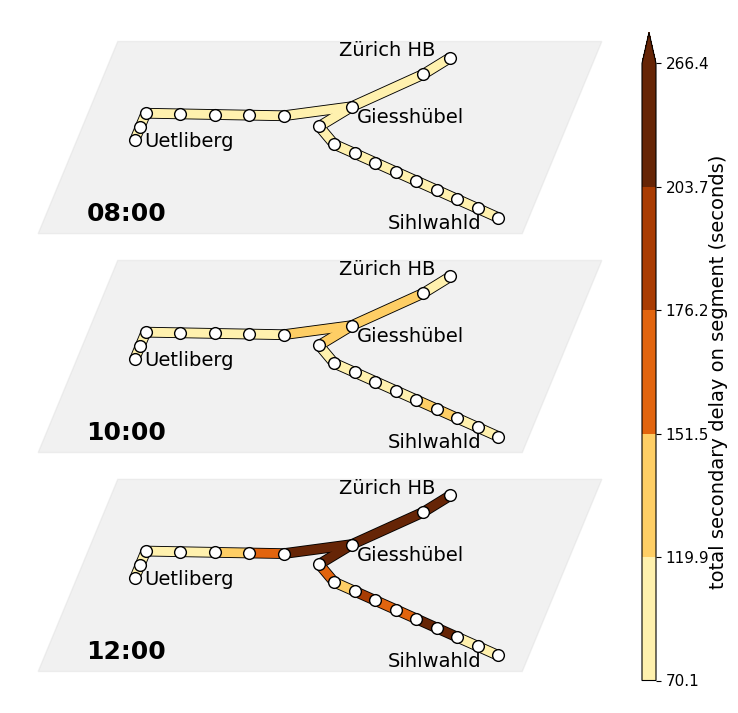

In [39]:
ystandardlower = 0.4
ystandardlower2 = 0.6
ystandardupper = -0.35
xstandardupper = 0.7
xstandardlower2 = 0
stationposdelta = {
    "Zürich HB SZU": (-1.5,-1*ystandardlower),
    'Selnau': (+0.7,-ystandardlower),
    'Giesshübel': (+1.4,-7*ystandardlower),
    'Saalsporthalle': (-1.2+xstandardlower2,-ystandardlower2),
    'Brunau': (-0.75+xstandardlower2,-ystandardlower2),
    'Manegg': (-0.8+xstandardlower2,-ystandardlower2),
    'Leimbach': (-0.9+xstandardlower2,-ystandardlower2-0.05),
    'Sood-Oberleimbach': (-1.55+xstandardlower2,-ystandardlower2),
    'Adliswil': (-0.8+xstandardlower2,-ystandardlower2),
    'Sihlau': (-0.7+xstandardlower2,-ystandardlower2),
    'Wildpark-Höfli': (-1.25+xstandardlower2,-ystandardlower2),
    'Langnau-Gattikon': (-1.4+xstandardlower2,-ystandardlower2), 
    'Sihlwahld': (-1.5+xstandardlower2,-3.5*ystandardlower2),
    'Binz': (xstandardupper-0.35,-ystandardupper+0.05),
    'Friesenberg': (xstandardupper,-ystandardupper),
    'Schweighof': (xstandardupper-0.05,-ystandardupper),
    'Triemli': (xstandardupper-0.25,-ystandardupper),
    'Uitikon': (-1.3,-ystandardupper),
    'Waldegg': (-1.3,-ystandardupper),
    'Ringlikon': (-0.8,-0.3), 
    'Uetliberg': (1.3,-1.5),
    }
generate_network_plot(results, node_station_pos, 
                      newnewpositions,
                      stations_data, 
                      station_to_node,
                      stationposdelta,
                      stationposrot, 
                      ytilt = 1,
                      xtilt = 1,
                      rotangledeg = -5,
                      save_path="figures/stacked_heatmap.pdf")